In [12]:
import pickle
import psutil
import sys
from pathlib import Path
from typing import Dict, List, Union

import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import KNNImputer

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, TargetEncoder
from xgboost import XGBClassifier

from fwi_predict.constants import TZ_STRING, WQ_RANGES
from fwi_predict.wq import get_in_required_range

sys.path.append("..")
from scripts.clean_ara_measurements import column_map

In [13]:
# Load data and remove columns that we don't want for training
predict_df = pd.read_csv("../data/predict_dfs/train/jun_21_dec_24_w_metadata_predict_df.csv",
                         parse_dates=['sample_dt'],
                        index_col=0)

num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'geometry', 'pond_status', 'group', 'date', 'follow_up'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

# Get parameters for classification problem
predict_df['morning'] = predict_df['hour'] < 12
predict_df['month'] = predict_df['sample_dt'].dt.month

predict_df = predict_df.drop(columns=['ammonia_mg_per_L', 'ph', 'turbidity_cm'])
predict_df['do_in_range'] = get_in_required_range('do_mg_per_L',
                                                  predict_df['do_mg_per_L'], 
                                                  predict_df['morning'].apply(lambda x: 'morning' if x else 'evening'))
                                                  

In [14]:
predict_df['do_in_range'].value_counts(dropna=True)

do_in_range
within    4847
below      631
above      158
            10
Name: count, dtype: int64

In [15]:
predict_df['date'] = predict_df['sample_dt'].dt.date
predict_df['region'] = predict_df['pond_id'].str[:2]

In [16]:
winkler_df = predict_df[predict_df['winkler']]
len(winkler_df)

1409

In [17]:
winkler_df['do_in_range'].value_counts() * 100 / len(winkler_df)

do_in_range
within    93.470546
below      4.755145
above      1.774308
Name: count, dtype: float64

These should roughly be our minimum targets for model precision

In [18]:
target = 'do_mg_per_L'

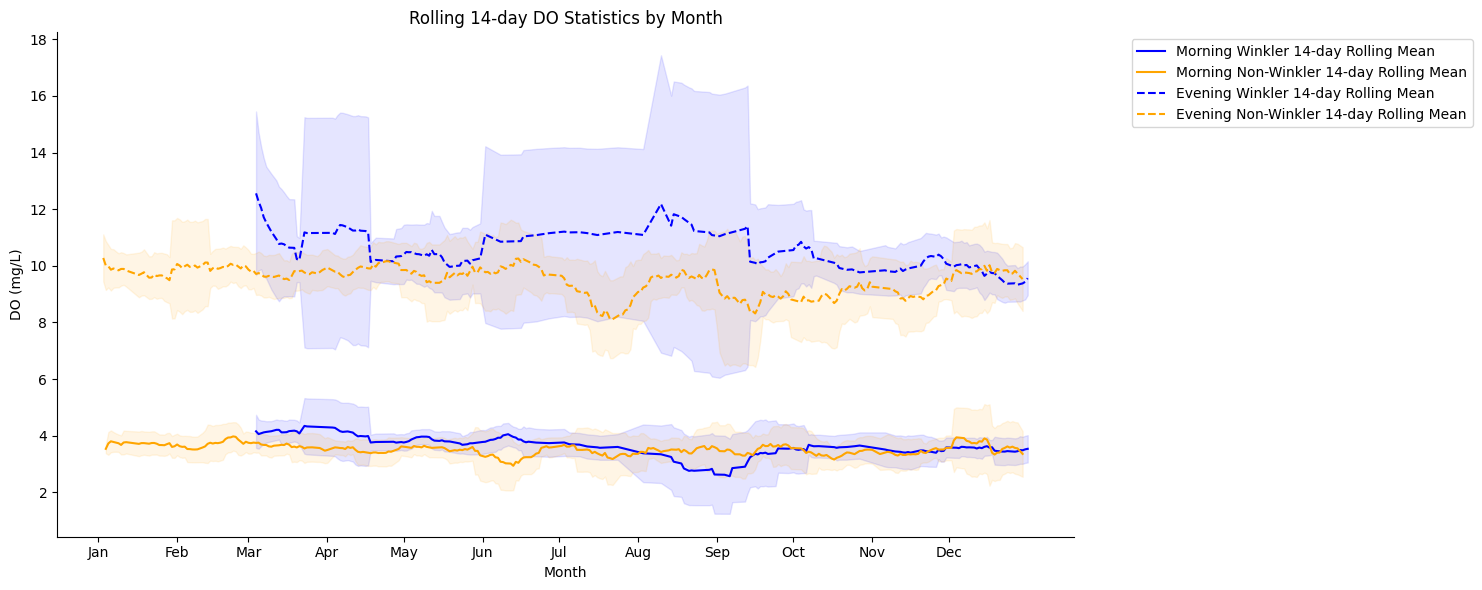


Summary Statistics for All DO Measurements:


,time_of_day,measurement_type,mean,std,count
0,Morning,Winkler,3.625760,0.803866,757.0
1,Morning,Non-Winkler,3.514026,1.028409,2146.0
2,Evening,Winkler,10.229601,2.030890,652.0
3,Evening,Non-Winkler,9.547669,1.873054,2081.0


In [19]:
# Function to calculate rolling averages for DO measurements
def calculate_rolling_averages(df, window_size=7):
    """
    Calculate rolling window averages for dissolved oxygen measurements,
    separated by morning/evening and measurement type.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing DO measurements with 'morning' and 'winkler' columns
    window_size : int, default=7
        Size of the rolling window in days
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with rolling averages for each group
    """
    # Create a copy to avoid SettingWithCopyWarning
    result_df = df.copy()
    
    # Add day of year column
    result_df['day_of_year'] = result_df['sample_dt'].dt.dayofyear
    
    # Ensure data is sorted by day of year
    result_df = result_df.sort_values('day_of_year')
    
    # Calculate rolling statistics for each combination of morning/evening and winkler/non-winkler
    groups = []
    for is_morning in [True, False]:
        for is_winkler in [True, False]:
            data = result_df[(result_df['morning'] == is_morning) & 
                           (result_df['winkler'] == is_winkler)]
            
            daily_means = data.groupby(['day_of_year'])['do_mg_per_L'].mean()
            rolling_mean = daily_means.rolling(window=window_size, min_periods=3).mean()
            rolling_std = daily_means.rolling(window=window_size, min_periods=3).std()
            
            groups.append({
                'data': rolling_mean,
                'std': rolling_std,
                'label': f'{"Morning" if is_morning else "Evening"} {"Winkler" if is_winkler else "Non-Winkler"}',
                'color': 'blue' if is_winkler else 'orange',  # Same color for same measurement type
                'linestyle': '-' if is_morning else '--'
            })

    # Plot the results
    fig, ax = plt.subplots(figsize=(15, 6))
    
    for group in groups:
        group['data'].plot(ax=ax, 
                         label=f"{group['label']} {window_size}-day Rolling Mean", 
                         color=group['color'],
                         linestyle=group['linestyle'])
        ax.fill_between(group['data'].index, 
                       group['data'] - group['std'],
                       group['data'] + group['std'],
                       alpha=0.1, 
                       color=group['color'])
    
    # Set x-axis ticks to show months
    month_ticks = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]  # Approximate middle of each month
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ax.set_xticks(month_ticks)
    ax.set_xticklabels(month_labels)
    
    ax.set_title(f'Rolling {window_size}-day DO Statistics by Month')
    ax.set_xlabel('Month')
    ax.set_ylabel('DO (mg/L)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()

    # Calculate summary statistics
    summary_stats = []
    for is_morning in [True, False]:
        for is_winkler in [True, False]:
            data = result_df[(result_df['morning'] == is_morning) & 
                           (result_df['winkler'] == is_winkler)]
            stats = data['do_mg_per_L'].agg(['mean', 'std', 'count']).to_dict()
            stats['time_of_day'] = 'Morning' if is_morning else 'Evening'
            stats['measurement_type'] = 'Winkler' if is_winkler else 'Non-Winkler'
            summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df = summary_df[['time_of_day', 'measurement_type', 'mean', 'std', 'count']]
    
    print("\nSummary Statistics for All DO Measurements:")
    display(summary_df)

# Calculate rolling averages with 7-day window
rolling_window = 14
calculate_rolling_averages(predict_df, window_size=rolling_window)


In [20]:
# Create interactive plot of DO over time by pond
# Get all ponds ordered by number of observations
pond_order = winkler_df.groupby('pond_id').size().sort_values(ascending=False).index.tolist()
winkler_df['date'] = winkler_df['sample_dt'].dt.date

# Get top 10 ponds for initial visibility
top_10_ponds = pond_order[:10]

fig = px.line(winkler_df, 
                 x='date', 
                 y='do_mg_per_L',
                 color='pond_id',
                 facet_row='morning',
                 title='Dissolved Oxygen Over Time by Pond',
                 labels={'do_mg_per_L': 'Dissolved Oxygen (mg/L)',
                        'date': 'Date',
                        'pond_id': 'Pond ID',
                        'morning': 'Morning'},
                 category_orders={'pond_id': pond_order},
                 height=800)

# Add shaded regions for required DO ranges based on time of day
# Morning range (3-5 mg/L)
fig.add_hrect(y0=3, y1=5,
              fillcolor="green", opacity=0.2,
              layer="below", line_width=0,
              annotation_text="Required Range",
              annotation_position="top right",
              row=1)  # Morning facet

# Evening range (8-12 mg/L) 
fig.add_hrect(y0=8, y1=12,
              fillcolor="green", opacity=0.2,
              layer="below", line_width=0,
              annotation_text="Required Range",
              annotation_position="top right",
              row=2)  # Evening facet

# Update layout
fig.update_layout(
    showlegend=True,
    legend_title_text='Pond ID',
    title_x=0.5,
    height=800  # Increased height for better visibility
)

# Show only top 10 ponds initially but allow selection of others
fig.for_each_trace(lambda t: t.update(visible='legendonly') 
                   if t.name not in top_10_ponds 
                   else t.update(visible=True))

fig.show()


C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\3852230076.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winkler_df['date'] = winkler_df['sample_dt'].dt.date


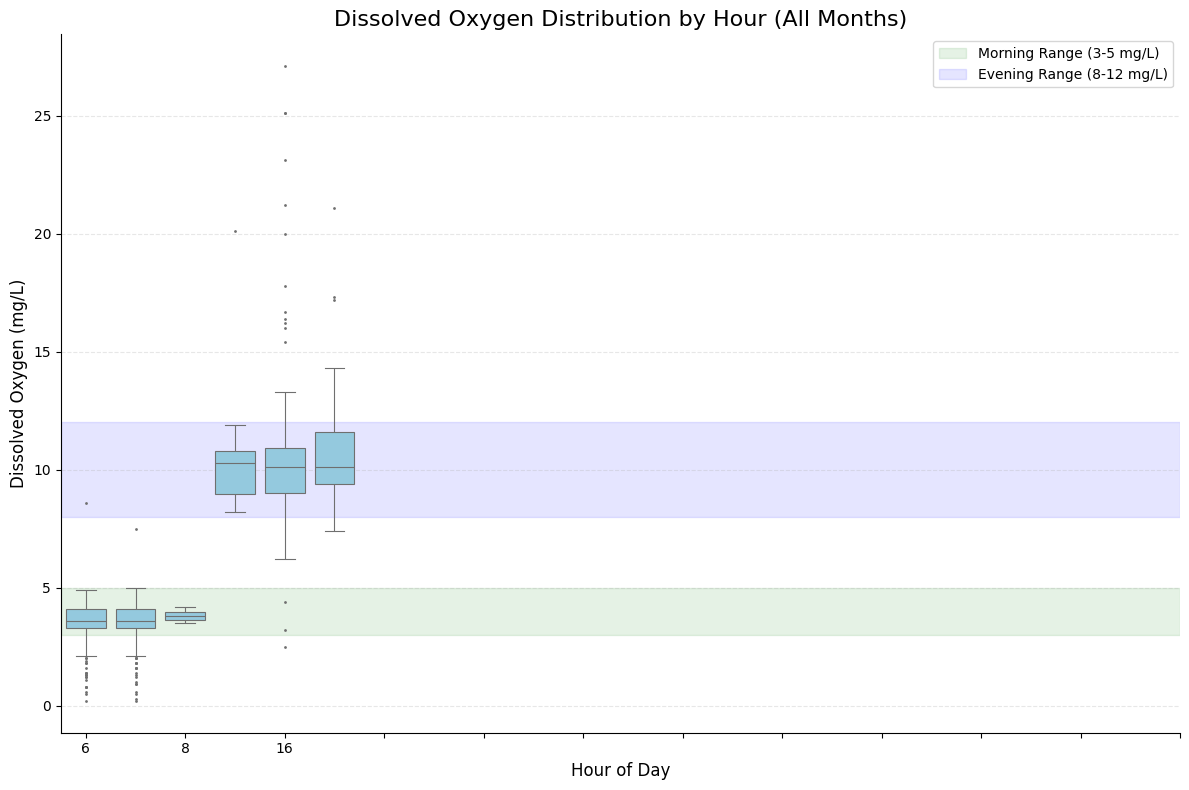

In [21]:
# Create a figure for boxplots of dissolved oxygen by hour (not disaggregated by month)
plt.figure(figsize=(12, 8))

# Create boxplot of DO by hour
ax = sns.boxplot(x='hour', y='do_mg_per_L', data=winkler_df, 
                color='skyblue', fliersize=1, linewidth=0.8,
                order=sorted(winkler_df['hour'].unique()))  # Sort hours numerically

# Customize the appearance
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Dissolved Oxygen (mg/L)', fontsize=12)
plt.title('Dissolved Oxygen Distribution by Hour (All Months)', fontsize=16)
plt.xticks(range(0, 24, 2))  # Set x-ticks every 2 hours

# Remove spines to make it prettier
sns.despine(left=False, bottom=False)

# Add light grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add shaded regions for required DO ranges
plt.axhspan(3, 5, alpha=0.1, color='green', label='Morning Range (3-5 mg/L)')
plt.axhspan(8, 12, alpha=0.1, color='blue', label='Evening Range (8-12 mg/L)')

# Add legend
plt.legend(loc='best', frameon=True)

# Adjust layout
plt.tight_layout()
plt.show()


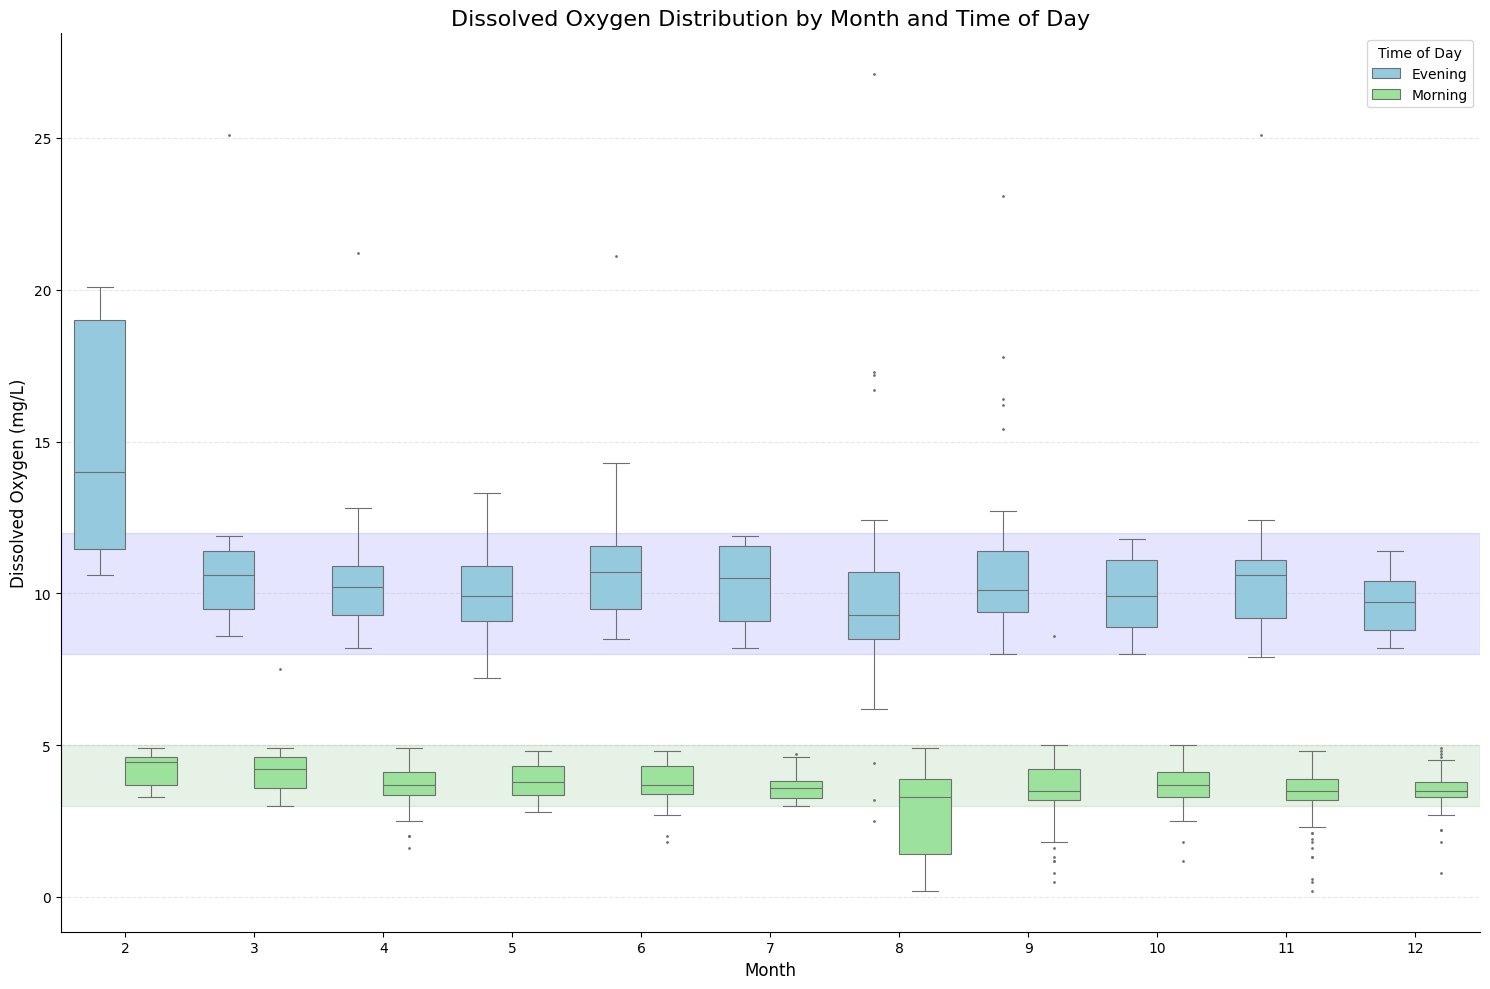

In [22]:
# Create a figure for boxplots of dissolved oxygen by month, hued by time of day
plt.figure(figsize=(15, 10))

# Create a new column to categorize time as morning or evening for this visualization
winkler_df_viz = winkler_df.copy()
winkler_df_viz['time_of_day'] = 'Evening'
winkler_df_viz.loc[winkler_df_viz['hour'] < 12, 'time_of_day'] = 'Morning'

# Create boxplot of DO by month, with time of day as hue
ax = sns.boxplot(x='month', y='do_mg_per_L', hue='time_of_day', data=winkler_df_viz, 
                 palette={'Morning': 'lightgreen', 'Evening': 'skyblue'},
                 fliersize=1, linewidth=0.8)

# Customize the appearance
plt.xlabel('Month', fontsize=12)
plt.ylabel('Dissolved Oxygen (mg/L)', fontsize=12)
plt.title('Dissolved Oxygen Distribution by Month and Time of Day', fontsize=16)

# Adjust legend
plt.legend(title='Time of Day', loc='best')

# Remove spines to make it prettier
sns.despine(left=False, bottom=False)

# Add light grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add shaded regions for required DO ranges
plt.axhspan(3, 5, alpha=0.1, color='green', label='Morning Range (3-5 mg/L)')
plt.axhspan(8, 12, alpha=0.1, color='blue', label='Evening Range (8-12 mg/L)')

# Adjust layout
plt.tight_layout()
plt.show()



C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\1165434181.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\1165434181.py:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\1165434181.py:38: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



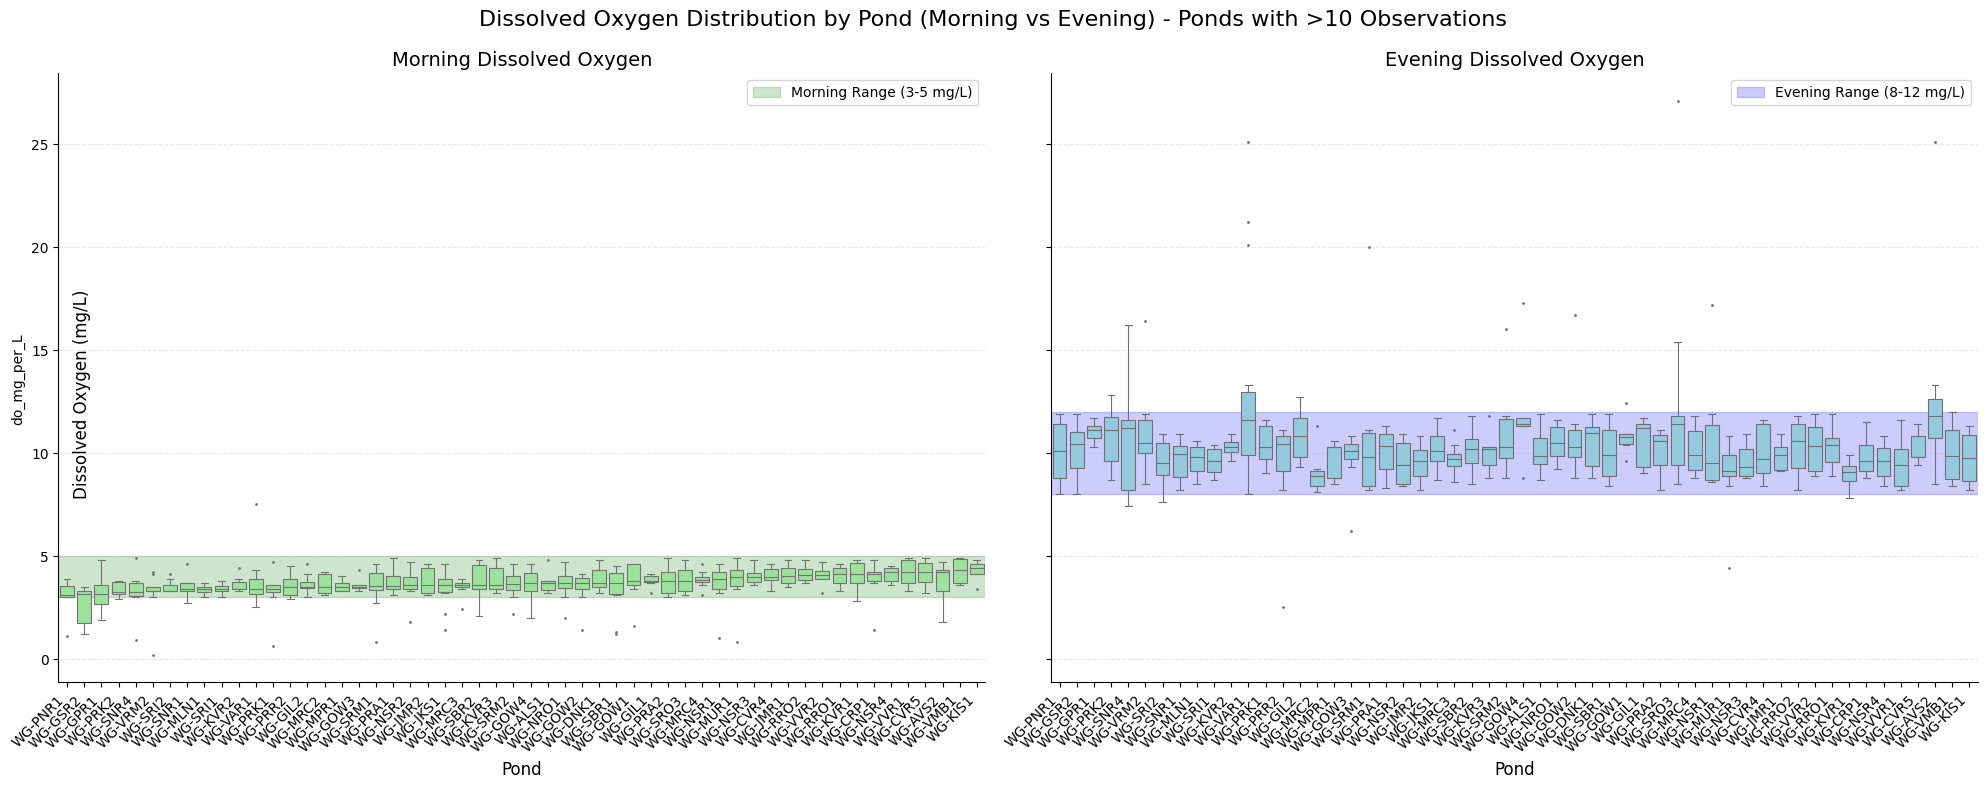

In [23]:
# Create a new column to categorize time as morning or evening
winkler_df['time_of_day'] = 'Evening'
winkler_df.loc[winkler_df['hour'] < 12, 'time_of_day'] = 'Morning'

# Count observations per pond
pond_counts = winkler_df.groupby('pond_id').size()
valid_ponds = pond_counts[pond_counts > 10].index.tolist()

# Filter to only include ponds with more than 10 observations
filtered_df = winkler_df[winkler_df['pond_id'].isin(valid_ponds)]

# Calculate medians for sorting by morning values
morning_medians = filtered_df[filtered_df['time_of_day'] == 'Morning'].groupby('pond_id')['do_mg_per_L'].median()
pond_order = morning_medians.sort_values().index.tolist()

# Create a figure for faceted boxplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Colors for each time of day
colors = {'Morning': 'lightgreen', 'Evening': 'skyblue'}

# Create separate boxplots for morning and evening
for i, time_period in enumerate(['Morning', 'Evening']):
    # Filter data for this time period
    period_data = filtered_df[filtered_df['time_of_day'] == time_period]
    
    # Create boxplot
    sns.boxplot(x='pond_id', y='do_mg_per_L', 
                data=period_data, 
                color=colors[time_period],
                fliersize=1, linewidth=0.8,
                order=pond_order,
                ax=axes[i])
    
    # Customize appearance
    axes[i].set_xlabel('Pond', fontsize=12)
    axes[i].set_title(f'{time_period} Dissolved Oxygen', fontsize=14)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    # Remove spines
    sns.despine(ax=axes[i], left=False, bottom=False)
    
    # Add grid
    axes[i].grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add appropriate shaded region for required DO range
    if time_period == 'Morning':
        axes[i].axhspan(3, 5, alpha=0.2, color='green', label='Morning Range (3-5 mg/L)')
    else:
        axes[i].axhspan(8, 12, alpha=0.2, color='blue', label='Evening Range (8-12 mg/L)')
    
    # Add legend
    axes[i].legend(loc='best', frameon=True)

# Set common y-label
fig.text(0.04, 0.5, 'Dissolved Oxygen (mg/L)', va='center', rotation='vertical', fontsize=12)

# Add overall title
plt.suptitle('Dissolved Oxygen Distribution by Pond (Morning vs Evening) - Ponds with >10 Observations', fontsize=16, y=0.98)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


In [24]:
# Create half hour period from sample_dt (0-47 representing each 30 min period in day)
predict_df['half_hour'] = (predict_df['sample_dt'].dt.hour * 2 + (predict_df['sample_dt'].dt.minute >= 30).astype(int))


In [25]:
# Calculate rolling averages and variations for morning and evening
def plot_rolling_stats(df, window=7):
    """
    Plot rolling statistics for DO levels, separated by morning and evening.
    
    Args:
        df: DataFrame with DO measurements
        window: Rolling window size in days
    """
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Define morning and evening periods
    # Morning: 6am-12pm, Evening: 6pm-12am
    morning_mask = (df['sample_dt'].dt.hour < 12)
    evening_mask = (df['sample_dt'].dt.hour >= 12)
    
    # Calculate rolling statistics for morning
    morning_data = df[morning_mask]
    morning_daily_means = morning_data.groupby(['date'])['do_mg_per_L'].mean()
    morning_rolling_mean = morning_daily_means.rolling(window=window).mean()
    morning_rolling_std = morning_daily_means.rolling(window=window).std()
    
    # Calculate rolling statistics for evening
    evening_data = df[evening_mask]
    evening_daily_means = evening_data.groupby(['date'])['do_mg_per_L'].mean()
    evening_rolling_mean = evening_daily_means.rolling(window=window).mean()
    evening_rolling_std = evening_daily_means.rolling(window=window).std()
    
    # Plot morning data
    morning_rolling_mean.plot(ax=ax, label=f'Morning {window}-day Rolling Mean', color='green')
    ax.fill_between(morning_rolling_mean.index, 
                    morning_rolling_mean - morning_rolling_std,
                    morning_rolling_mean + morning_rolling_std,
                    alpha=0.2, color='green', label='Morning ±1 std')
    
    # Plot evening data
    evening_rolling_mean.plot(ax=ax, label=f'Evening {window}-day Rolling Mean', color='blue')
    ax.fill_between(evening_rolling_mean.index, 
                    evening_rolling_mean - evening_rolling_std,
                    evening_rolling_mean + evening_rolling_std,
                    alpha=0.2, color='blue', label='Evening ±1 std')
    
    ax.set_title(f'Rolling {window}-day DO Statistics (Morning vs Evening)')
    ax.set_ylabel('DO (mg/L)')
    ax.legend()
    plt.show()

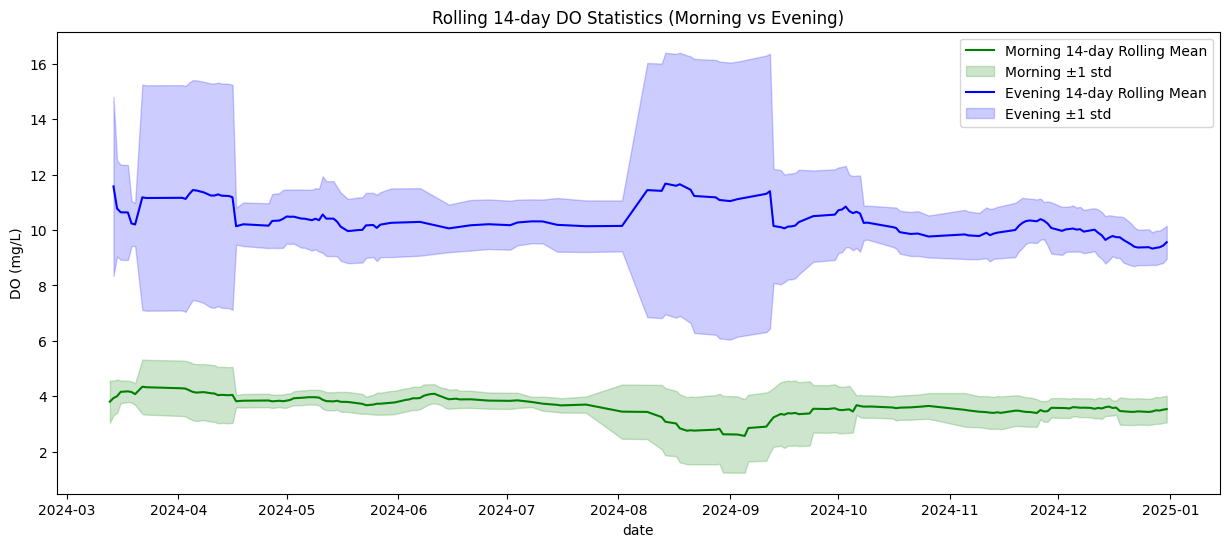

In [26]:
plot_rolling_stats(winkler_df, window=14)

In [27]:
taiwan_df = predict_df[predict_df['taiwan']]

C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\4086724317.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\4086724317.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



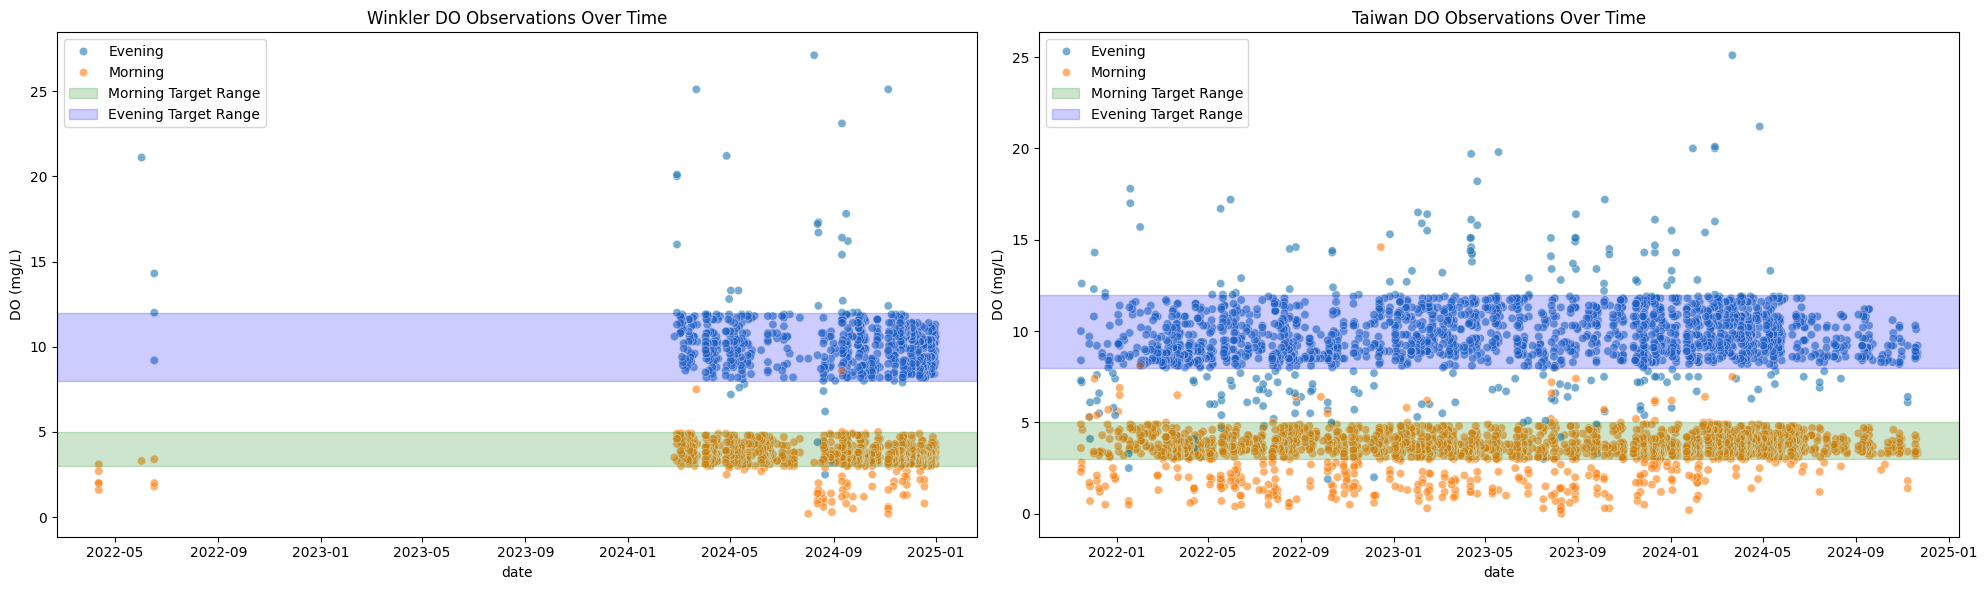

In [28]:
def plot_do_observations_with_bands(winkler_df, taiwan_df):
    """
    Plot DO observations over time with bands indicating in/out of range,
    colored by morning/evening. Creates a 1x2 subplot comparing Winkler and Taiwan data.
    
    Args:
        winkler_df: DataFrame with Winkler DO measurements
        taiwan_df: DataFrame with Taiwan DO measurements
    """
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    for df, ax, title in [(winkler_df, ax1, 'Winkler'), (taiwan_df, ax2, 'Taiwan')]:
        # Create morning/evening labels
        df['time_of_day'] = df['sample_dt'].dt.hour.apply(lambda x: 'Morning' if x < 12 else 'Evening')
        
        # Plot scatter points
        sns.scatterplot(data=df,
                        x='date',
                        y='do_mg_per_L',
                        hue='time_of_day',
                        alpha=0.6,
                        ax=ax)
        
        # Add bands for acceptable DO ranges
        # Morning range: ~3-5 mg/L
        ax.axhspan(3, 5, alpha=0.2, color='green', label='Morning Target Range')
        # Evening range: ~8-12 mg/L  
        ax.axhspan(8, 12, alpha=0.2, color='blue', label='Evening Target Range')
        
        ax.set_title(f'{title} DO Observations Over Time')
        ax.set_ylabel('DO (mg/L)')
        ax.legend(title='')
    
    plt.tight_layout()
    plt.show()

plot_do_observations_with_bands(winkler_df, taiwan_df)


C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\908577023.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\908577023.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_29056\908577023.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

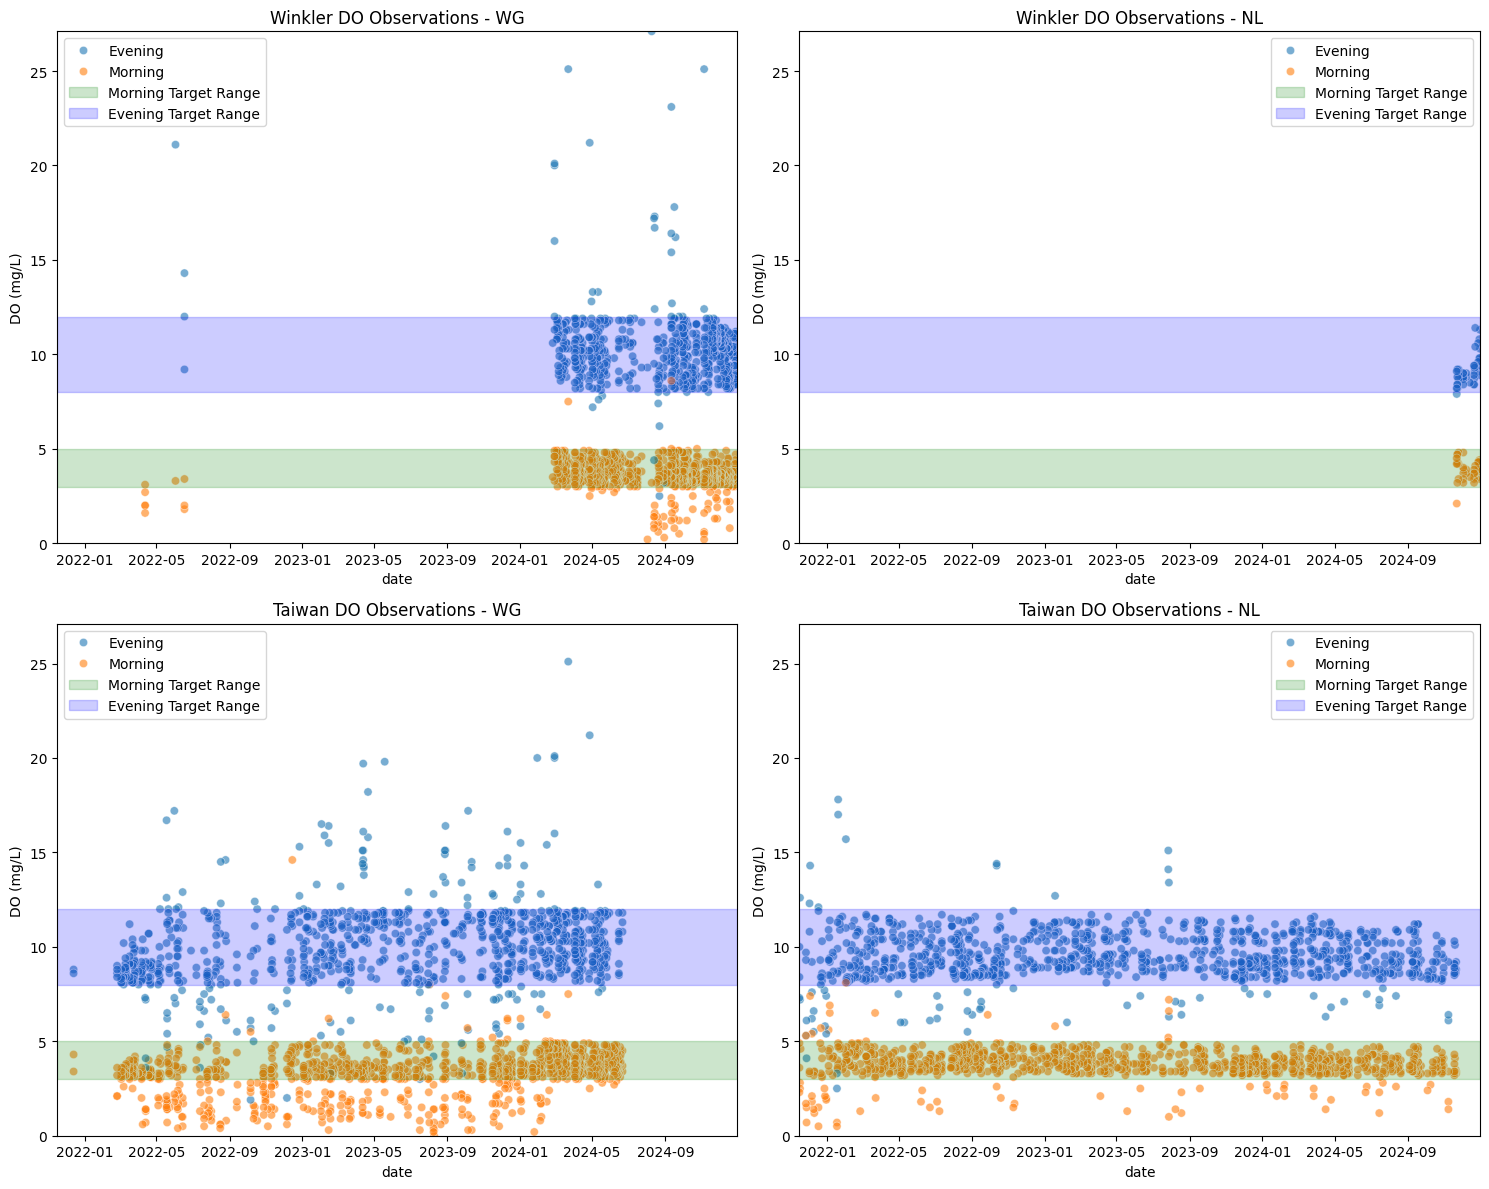

In [33]:
def plot_do_observations_with_bands_by_region(winkler_df, taiwan_df):
    """
    Plot DO observations by day of year with bands indicating in/out of range,
    colored by morning/evening. Creates a 2x2 subplot comparing Winkler and Taiwan data
    across different regions.
    
    Args:
        winkler_df: DataFrame with Winkler DO measurements
        taiwan_df: DataFrame with Taiwan DO measurements
    """
    regions = set(winkler_df['region'].unique().tolist() + taiwan_df['region'].unique().tolist())
    fig, axes = plt.subplots(len(regions), 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Find global min and max for x and y axes
    min_date = min(winkler_df['date'].min(), taiwan_df['date'].min())
    max_date = max(winkler_df['date'].max(), taiwan_df['date'].max())
    min_do = min(winkler_df['do_mg_per_L'].min(), taiwan_df['do_mg_per_L'].min())
    max_do = max(winkler_df['do_mg_per_L'].max(), taiwan_df['do_mg_per_L'].max())
    
    plot_idx = 0
    for df, title in [(winkler_df, 'Winkler'), (taiwan_df, 'Taiwan')]:
        for region in regions:
            ax = axes[plot_idx]
            region_df = df[df['region'] == region]
            
            region_df['time_of_day'] = region_df['sample_dt'].dt.hour.apply(lambda x: 'Morning' if x < 12 else 'Evening')
            
            sns.scatterplot(data=region_df,
                            x='date',
                            y='do_mg_per_L',
                            hue='time_of_day',
                            alpha=0.6,
                            ax=ax)
            
            ax.axhspan(3, 5, alpha=0.2, color='green', label='Morning Target Range')
            ax.axhspan(8, 12, alpha=0.2, color='blue', label='Evening Target Range')
            
            ax.set_title(f'{title} DO Observations - {region}')
            ax.set_ylabel('DO (mg/L)')
            ax.legend(title='')
            
            # Set standardized x and y axes
            ax.set_xlim(min_date, max_date)
            ax.set_ylim(min_do, max_do)
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()

plot_do_observations_with_bands_by_region(winkler_df, taiwan_df)

C:\Users\squaade\AppData\Local\Temp\ipykernel_30200\2715338224.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_30200\2715338224.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\squaade\AppData\Local\Temp\ipykernel_30200\2715338224.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

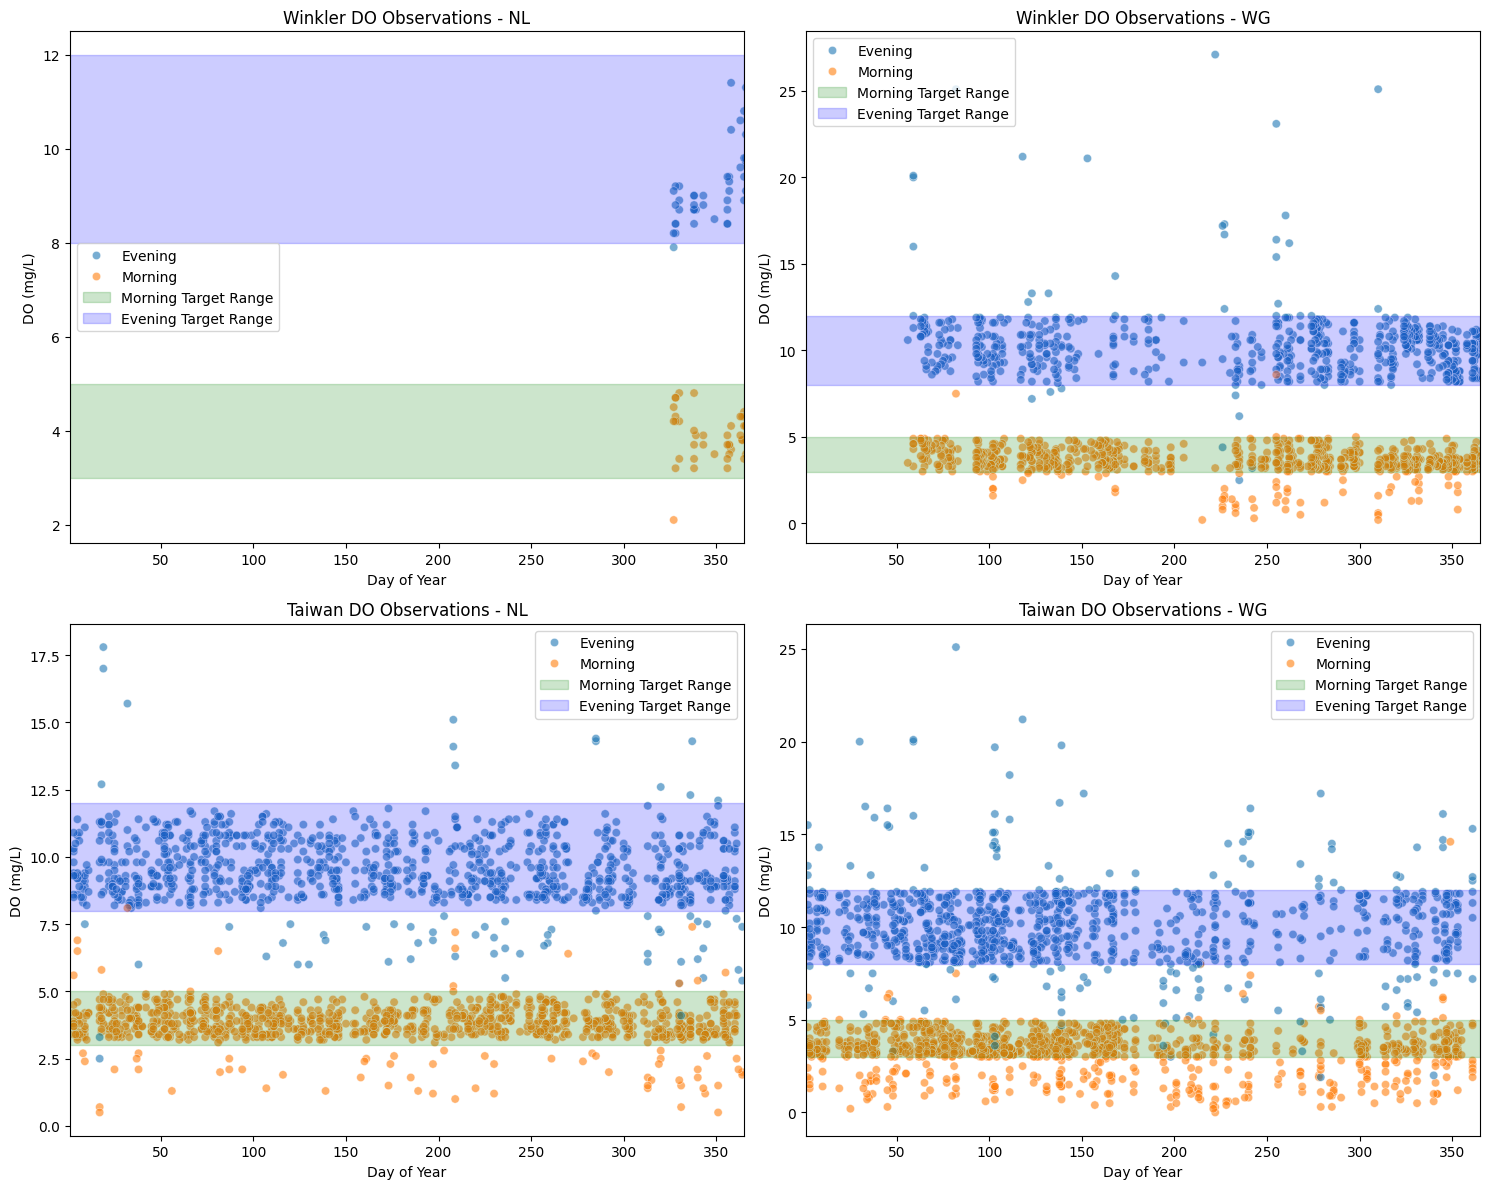

In [137]:
def plot_do_observations_with_bands_by_region(winkler_df, taiwan_df):
    """
    Plot DO observations by day of year with bands indicating in/out of range,
    colored by morning/evening. Creates a 2x2 subplot comparing Winkler and Taiwan data
    across different regions.
    
    Args:
        winkler_df: DataFrame with Winkler DO measurements
        taiwan_df: DataFrame with Taiwan DO measurements
    """
    # Create figure with four subplots (2x2)
    regions = set(winkler_df['region'].unique().tolist() + taiwan_df['region'].unique().tolist())
    fig, axes = plt.subplots(len(regions), 2, figsize=(15, 12))
    axes = axes.flatten()
    
    # Process each dataset and region combination
    plot_idx = 0
    for df, title in [(winkler_df, 'Winkler'), (taiwan_df, 'Taiwan')]:
        for region in regions:
            ax = axes[plot_idx]
            region_df = df[df['region'] == region]
            
            # Create morning/evening labels and day of year
            region_df['time_of_day'] = region_df['sample_dt'].dt.hour.apply(lambda x: 'Morning' if x < 12 else 'Evening')
            region_df['day_of_year'] = region_df['sample_dt'].dt.dayofyear
            
            # Plot scatter points
            sns.scatterplot(data=region_df,
                          x='day_of_year',
                          y='do_mg_per_L',
                          hue='time_of_day',
                          alpha=0.6,
                          ax=ax)
            
            # Add bands for acceptable DO ranges
            ax.axhspan(3, 5, alpha=0.2, color='green', label='Morning Target Range')
            ax.axhspan(8, 12, alpha=0.2, color='blue', label='Evening Target Range')
            
            ax.set_title(f'{title} DO Observations - {region}')
            ax.set_xlabel('Day of Year')
            ax.set_ylabel('DO (mg/L)')
            ax.legend(title='')
            
            # Set x-axis limits to full year
            ax.set_xlim(1, 365)
            
            plot_idx += 1
    
    plt.tight_layout()
    plt.show()

plot_do_observations_with_bands_by_region(winkler_df, taiwan_df)


We seem to have far more water quality issues in WG than in Nellore

In [69]:
def plot_do_heatmap(df):
    """
    Create a heatmap showing DO patterns by hour and month.
    
    Args:
        df: DataFrame with DO measurements
    """
    # Create pivot table
    pivot_data = df.pivot_table(
        values='do_mg_per_L',
        index='hour',
        columns='month',
        aggfunc='mean'
    )
    
    # Sort the columns (months) in chronological order
    month_order = sorted(pivot_data.columns, key=lambda x: pd.to_datetime(x, format='%B').month if isinstance(x, str) else x)
    pivot_data = pivot_data[month_order]
    
    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_data, 
                cmap='RdYlBu_r',
                center=np.mean(df['do_mg_per_L']),
                annot=True,
                fmt='.1f')
    plt.title('DO Levels by Hour and Month')
    plt.show()

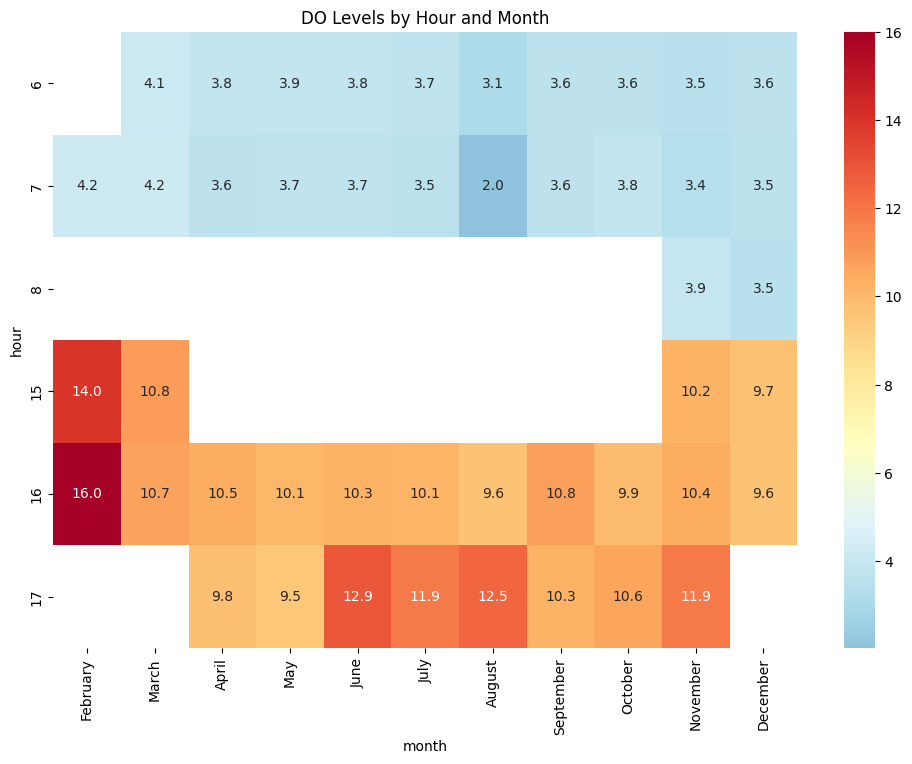

In [82]:
plot_do_heatmap(winkler_df)